## Set Up

In [1]:
# !/usr/env python3

'''
Output:
video captioning model itself and produce loss curve

Usage:
main document to train the video captioning model
'''

# set up
from __future__ import print_function
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
from util import *
from model.video_caption import sequence_2_sequence_LSTM
from load_caption_feature import *
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import gc

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Process and save data  
Load caption Xtrain, Xtest, ytrain, ytest, video_train, video_test and save them.  
Here in details, see **load_caption_feature.py**. Only need to run once, codes are going to save the data file. 

In [2]:
# load and save training data
num_frames = 15
size = (224, 224, 3)

# more balanced data
idx_path = os.getcwd() + '/datasets/x_train_ind_above400.npy'
Xtrain_idx = np.load(idx_path)
labels = np.load(os.getcwd() + '/datasets/y_train_mapped_above400.npy')

# if all videos then 
num_videos = len(Xtrain_idx)

tic = datetime.now()
# for clearing memory convenience
model = vgg_16_pretrained()
Xtr, ytr = load_features(model, num_videos, num_frames, Xtrain_idx, labels, size = (224, 224, 3), train_test_flag='train')

processing videos...
process 70/4270
process 140/4270
process 210/4270
process 280/4270
process 350/4270
process 420/4270
process 490/4270
process 560/4270
process 630/4270
process 700/4270
process 770/4270
process 840/4270
process 910/4270
process 980/4270
process 1050/4270
process 1120/4270
process 1190/4270
process 1260/4270
process 1330/4270
process 1400/4270
process 1470/4270
process 1540/4270
process 1610/4270
process 1680/4270
process 1750/4270
process 1820/4270
process 1890/4270
process 1960/4270
process 2030/4270
process 2100/4270
process 2170/4270
process 2240/4270
process 2310/4270
process 2380/4270
process 2450/4270
process 2520/4270
process 2590/4270
process 2660/4270
process 2730/4270
process 2800/4270
process 2870/4270
process 2940/4270
process 3010/4270
process 3080/4270
process 3150/4270
process 3220/4270
process 3290/4270
process 3360/4270
process 3430/4270
process 3500/4270
process 3570/4270
process 3640/4270
process 3710/4270
process 3780/4270
process 3850/4270
proc

In [5]:
# clear memory
del Xtr
del ytr
model = None
gc.collect()

0

In [6]:
# load and save test data
num_frames_test = 15
size = (224, 224, 3)

# more balanced data
idx_path = os.getcwd() + '/datasets/x_test_ind_above400.npy'
Xtest_idx = np.load(idx_path)
ytest = np.load(os.getcwd() + '/datasets/y_test_mapped_above400.npy')

# if all videos then 
num_videos_test = len(Xtest_idx)

model = vgg_16_pretrained()
Xte, yte = load_features(model, num_videos_test, num_frames_test, Xtest_idx, ytest, size = (224, 224, 3), train_test_flag='test')

processing videos...
process 30/1830
process 60/1830
process 90/1830
process 120/1830
process 150/1830
process 180/1830
process 210/1830
process 240/1830
process 270/1830
process 300/1830
process 330/1830
process 360/1830
process 390/1830
process 420/1830
process 450/1830
process 480/1830
process 510/1830
process 540/1830
process 570/1830
process 600/1830
process 630/1830
process 660/1830
process 690/1830
process 720/1830
process 750/1830
process 780/1830
process 810/1830
process 840/1830
process 870/1830
process 900/1830
process 930/1830
process 960/1830
process 990/1830
process 1020/1830
process 1050/1830
process 1080/1830
process 1110/1830
process 1140/1830
process 1170/1830
process 1200/1830
process 1230/1830
process 1260/1830
process 1290/1830
process 1320/1830
process 1350/1830
process 1380/1830
process 1410/1830
process 1440/1830
process 1470/1830
process 1500/1830
process 1530/1830
process 1560/1830
process 1590/1830
process 1620/1830
process 1650/1830
process 1680/1830
process

In [10]:
# clean memory
del Xte
del yte
model = None
gc.collect()

0

In [11]:
# save input frames train and test
curr = os.getcwd() + '/datasets'
def save_frames(X, vid_ls, mode = 'train'):
    X = X.reshape((-1, 15, 4096))
    assert X.shape[0] == len(vid_ls)
    input_frames = {}
    for i in range(X.shape[0]):
        vid = vid_ls[i]
        input_frames[vid] = Xtr[i]
    pickle.dump(input_frames, open(curr + '/input_frames_' + mode + '.pickle', 'wb'))

vid_train = np.load(curr + '/videoIdtrain_allCap_15frames.npy')
Xtr = np.load(curr + '/Xtrain_allCap_15frames.npy')
Xte = np.load(curr + '/Xtest_allCap_15frames.npy')
vid_test = np.load(curr + '/videoIdtest_allCap_15frames.npy')
save_frames(Xtr, vid_train, mode = 'train')
save_frames(Xte, vid_test, mode = 'test')

## Model setup and train

### Model Configuration and Parameters 
Parameters:  

* model_name: the name of model, here we refer sequence to sequence model from [1](https://arxiv.org/abs/1505.00487);  
* state_size: lstm encoder and encoder state dimension  
* learning_rate: learning rate  
* input_size: vector size input to lstm, here we use pretrained VGG16 output 4096 dimension  
* batch_size: batch size  
* max_sentence_length: fixed length for captions, default is 20 
* word_vector_size: depends on vocabulary chosen, here is 50, but can be changed 
* voc_size: depends on vocabulary created, if self-created vocabulary, it is 6169, if glove
* n_epoches: the number of epoches to run  
* num_frames: frame number  
* hidden_size: lstm encoder and encoder hidden dimension 

**Reference**  
[1] Venugopalan, S., Rohrbach, M., Donahue, J., Mooney, R., Darrell, T., & Saenko, K. (2015). Sequence to sequence-video to text. In Proceedings of the IEEE International Conference on Computer Vision (pp. 4534-4542).  

In [2]:
# define parameters
lr = 1e-1
hidden_size = 1000
state_size = 100
batch_size = 64
voc_size = 6169
epoch = 100
word_dim = 50

logging.basicConfig(level=logging.INFO)
#=======Change These===============================
tf.app.flags.DEFINE_string("model_name", "sequence2sequence", "name of the model")
tf.app.flags.DEFINE_integer("state_size", state_size, "Size of each model layer.")
tf.app.flags.DEFINE_float("learning_rate", lr, "Base Learning rate.")
#==================================================

tf.app.flags.DEFINE_float("input_size", 4096, "input size for each frame")
tf.app.flags.DEFINE_integer("batch_size", batch_size, "how many videos put per run")
tf.app.flags.DEFINE_integer("max_sentence_length", 20, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", word_dim, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("voc_size", voc_size, "vocabulary size")
tf.app.flags.DEFINE_integer("n_epochs", epoch, "number of epoch to run")
tf.app.flags.DEFINE_integer("num_frames", 15, "number of frames per video")
tf.app.flags.DEFINE_integer("hidden_size", hidden_size, "output size of LSTM encoder and decoder")
FLAGS = tf.app.flags.FLAGS        

### Load Training Data

In [3]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

curPath = os.getcwd()
dataPath = curPath + "/datasets/"

# pick first 100 for debugging purpose
# load data
sample_size = 4270
wvector_dim = 50
is_training = True
input_frames_train, captions_train, \
        word_dict, word2Index, index2Word = load_caption_data(sample_size, dataPath, train = is_training)
word_embedding = word_embedding_array(word_dict, wvector_dim, word2Index) 
print('Finish loading training data!')

Finish loading training data!


### Build Model Graph  
In details, see **model/video_caption.py**.   
We refer to sequence to sequence model to build two LSTM layers. One is encoder, and the other is decoder. The cell number of decoder depends on the maximum caption length we set. Here we choose 20 here by exploring the distribution of captions. In order to make encoder have same length of outputs, we add pad cells to encoder. Encoder accept 15 frames VGG16 outputs so that it has 15 cells. 

In [13]:
# build model graph
tf.reset_default_graph()
model = sequence_2_sequence_LSTM(word_embedding, FLAGS)
model.build()

start building model ...
zt shape:  (?, 50)
embedding shape:  (6169, 50)


RuntimeError: No active exception to reraise

In [9]:
# check variables
for v in tf.trainable_variables():
    print(v)

<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/weights:0' shape=(5096, 4000) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/biases:0' shape=(4000,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/weights:0' shape=(2050, 4000) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/biases:0' shape=(4000,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_scores/kernel:0' shape=(1000, 50) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_scores/bias:0' shape=(50,) dtype=float32_ref>


In [10]:
# run training mode
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    out = model.train(sess, (input_frames_train, captions_train), verbose = True)

InvalidArgumentError: Input to reshape is a tensor with 1280 values, but the requested shape has 123380
	 [[Node: loss/Reshape_1 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](loss/Cast, loss/Reshape_1/shape)]]
	 [[Node: LSTM_seq2seq/decoder/ArgMax_5/_33 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_11217_LSTM_seq2seq/decoder/ArgMax_5", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'loss/Reshape_1', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3012, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-d422ae91a850>", line 4, in <module>
    model.build()
  File "/home/sunjiajun/cs231n_project/model/video_caption.py", line 112, in build
    self.loss = self.add_loss_op(self.pred)
  File "/home/sunjiajun/cs231n_project/model/video_caption.py", line 229, in add_loss_op
    captions_flat = tf.cast(tf.reshape(captions, [N*T,]), tf.int32)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2510, in reshape
    name=name)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 1280 values, but the requested shape has 123380
	 [[Node: loss/Reshape_1 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](loss/Cast, loss/Reshape_1/shape)]]
	 [[Node: LSTM_seq2seq/decoder/ArgMax_5/_33 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_11217_LSTM_seq2seq/decoder/ArgMax_5", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [7]:
# unpack
val_loss, tr_loss, tr_pred, val_pred, train_vid, val_vid = out

### Plot Learning Curves

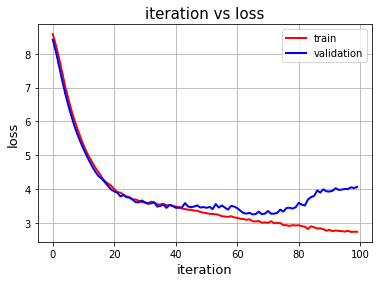

In [8]:
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/caption_learning_curve.png')

### Check batch captions

In [11]:
# check captions
batch_size = 24
# sample = tr_pred[idx] # training
# # sample = val_pred[idx] # validation 
# words = []
# embed_train = False # whether train embedding word

captions = {k: v for k, v in captions_train}
# caption check
for j in range(batch_size):
    words = []
    trues = []
    sample = tr_pred[j]
    vid = train_vid[j]
    cap = captions[vid]
    for idx, i in enumerate(sample):
        word = index2Word[i]
        true = index2Word[cap[idx]]
        if word not in ['<START>', '<END>', '<pad>']:
            words.append(word)
        if true not in ['<START>', '<END>', '<pad>']:
            trues.append(true)   
    print('Pred Caption: ', ' '.join(w for w in words))
    print('True Caption: ', ' '.join(t for t in trues))
    print('-'*50)

Pred Caption:  a a a a a a a
True Caption:  drawn cry prepared with roasted pawns red child and gram nasal south indian style
--------------------------------------------------
Pred Caption:  a a a a a a
True Caption:  one man and women talking something in a public
--------------------------------------------------
Pred Caption:  a a a a a a
True Caption:  a cartoon character is jumping up a ledge
--------------------------------------------------
Pred Caption:  a a a a a a a a a a
True Caption:  a man in a winter coat stand front of lights
--------------------------------------------------
Pred Caption:  a a a a a a a a a a a a
True Caption:  a man is kissing a woman while a woman and a baby laugh
--------------------------------------------------
Pred Caption:  a a a a a a a a the a a a
True Caption:  it is a collection of classic film quotes including james bond saying his name and the godfather says
--------------------------------------------------
Pred Caption:  a a a a a a
True

### Test Prediction and Evaluation

24